In [21]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [22]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [23]:
cutoff_date = '2022-04-30' ## len = 65, 월별 마지막 일자 잘 맞춰 줘야 함
test_period = 8 ## 예측 기간 (월)
corr_rate = 0.8 ## Lag corr rate

## <원 data set>

In [24]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [25]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 11.4 s
Wall time: 25.6 s


In [26]:
raw_y_set_shifted_merged

,date,y,y_8_,y2,y2_8_,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_8_,Howe Robinson Container Index,Howe Robinson Container Index_8_,Shanghai Containerized Freight Index (SCFI),...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_8_,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_8_,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_8_,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_8_,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_8_
0,2016-01-31,20.177268,NaN,20.680110,NaN,386.300000,NaN,449.750000,NaN,1051.760000,...,2.408986,NaN,2.484987,NaN,2.331150,NaN,2.432048,NaN,2.432048,NaN
1,2016-02-29,23.306868,NaN,24.462716,NaN,306.904762,NaN,447.750000,NaN,1066.213333,...,2.428055,NaN,2.472632,NaN,2.373518,NaN,2.408611,NaN,2.408611,NaN
2,2016-03-31,25.223010,NaN,28.364874,NaN,383.333333,NaN,449.000000,NaN,868.470000,...,2.680345,NaN,2.744366,NaN,2.611581,NaN,2.677025,NaN,2.677025,NaN
3,2016-04-30,25.308243,NaN,29.181978,NaN,607.476191,NaN,443.000000,NaN,748.392000,...,3.146489,NaN,3.210972,NaN,3.066818,NaN,3.118106,NaN,3.118106,NaN
4,2016-05-31,24.875099,NaN,27.810405,NaN,619.900000,NaN,447.000000,NaN,731.347500,...,3.784351,NaN,3.882355,NaN,3.701965,NaN,3.795215,NaN,3.795215,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-12-31,33.043478,11.326087,31.521739,12.097826,2832.111111,2475.050000,4509.000000,1854.500000,2455.538000,...,9.318571,5.991500,9.517619,6.180250,9.130952,5.885000,9.347143,6.069500,9.347143,6.069500
72,2022-01-31,43.260870,12.727273,38.652174,13.147727,1760.800000,2965.263158,4743.750000,2147.500000,2871.495000,...,10.718947,6.549524,10.927368,6.685714,10.405789,6.385714,10.625263,6.538095,10.625263,6.538095
73,2022-02-28,56.425000,13.340909,51.862500,14.329545,1834.900000,2932.000000,5252.250000,2568.800000,2840.395000,...,9.265000,6.393333,9.474000,6.519524,9.046250,6.271905,9.249500,6.379048,9.249500,6.379048
74,2022-03-31,71.086957,14.045455,69.576087,15.465909,2464.086957,3187.954545,5771.000000,3357.333333,2628.505000,...,10.260870,7.128636,10.461304,7.297500,10.055217,7.026591,10.266087,7.171818,10.266087,7.171818


#### 해당 기간에서의 12{test_period} lag corr best

In [27]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered[raw_y_set_shifted_merged_filtered.index.str.contains('y')==False]
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered[raw_y_set_shifted_merged_filtered.index.str.contains('y2')==False]
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.strip(f'_{test_period}') for word in futr_list ]

# futr_list.remove('y')
# futr_list.remove('y2')

futr_list

['Howe Robinson Container Index',
 'mn_mb_kg',
 'CCI_SWE',
 '옥수수 For Grain [미국(생산자 가격)] 현물',
 'African Rainbow(AFBOF)_Adj Close',
 '소맥 Durum [미국(생산자 가격)] 현물',
 '002466.SZ(Tianqi Lithium)_price_Adj Close',
 '002466.SZ(Tianqi Lithium)_price_High',
 '002466.SZ(Tianqi Lithium)_price_Close']

In [28]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y
Howe Robinson Container Index_8_,0.868455
mn_mb_kg_8_,0.842373
CCI_SWE_8_,0.835063
옥수수 For Grain [미국(생산자 가격)] 현물_8_,0.816466
African Rainbow(AFBOF)_Adj Close_8_,0.805874
소맥 Durum [미국(생산자 가격)] 현물_8_,0.803358
002466.SZ(Tianqi Lithium)_price_Adj Close_8_,0.802691
002466.SZ(Tianqi Lithium)_price_High_8_,0.802597
002466.SZ(Tianqi Lithium)_price_Close_8_,0.800593


#### 해당 기간에서의 12{test_period} corr best

In [29]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_var_list

['CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'CPI_BEL_TOT_AGRWTH',
 '중국 니켈 SEMIS 수입량',
 'CPI_PRT_TOT_AGRWTH',
 'CPI_GBR_TOT_FOODENRG_AGRWTH',
 'CPI_TUR_ENRG_AGRWTH',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 'CPI_LTU_TOT_AGRWTH',
 'CPI_GRC_TOT_AGRWTH',
 'CPI_DNK_ENRG_IDX2015',
 'al_lme_kg',
 'CPI_BEL_ENRG_AGRWTH',
 'CPI_OECD_TOT_FOODENRG_AGRWTH',
 'PPP_POL',
 'CPI_BEL_TOT_FOODENRG_AGRWTH',
 'CPI_GRC_ENRG_IDX2015',
 'CPI_KOR_TOT_FOODENRG_AGRWTH',
 'CPI_LTU_FOOD_AGRWTH',
 'CPI_NLD_ENRG_AGRWTH',
 'CPI_EST_TOT_FOODENRG_AGRWTH',
 'CPI_GRC_ENRG_AGRWTH',
 'CPI_DNK_TOT_AGRWTH',
 'Pilbara Mineral Limited_price_Adj Close',
 'HOUSECOST_KOR',
 'CPI_EST_TOT_AGRWTH',
 'CPI_GBR_TOT_AGRWTH',
 'CPI_ITA_TOT_AGRWTH',
 'CPI_ESP_TOT_FOODENRG_AGRWTH',
 'CPI_CHL_TOT_AGRWTH',
 'CPI_SWE_TOT_AGRWTH']

## scasler

In [30]:
# df_tgt = df.iloc[:,3:]

# scaler = StandardScaler()
# scaler.fit(df_tgt)
# arr = scaler.transform(df_tgt)
# df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
# df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [31]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [42]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [43]:
# len(df.loc[df.ds<'2021-06-30'])

In [32]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [14]:
futr_list

['Howe Robinson Container Index',
 'mn_mb_kg',
 'CCI_SWE',
 '옥수수 For Grain [미국(생산자 가격)] 현물',
 'African Rainbow(AFBOF)_Adj Close',
 '소맥 Durum [미국(생산자 가격)] 현물',
 '002466.SZ(Tianqi Lithium)_price_Adj Close',
 '002466.SZ(Tianqi Lithium)_price_High',
 '002466.SZ(Tianqi Lithium)_price_Close']

In [33]:
futr_temp = Y_test_df.drop(['y'], axis=1).copy()
# futr_list = [
#              'Shanghai Containerized Freight Index (SCFI)',
#              '대두 [미국(생산자 가격)] 현물',
#              # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
#              '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
#              # 'HOUSECOST_KOR'
#              ]
futr_date = futr_temp.iloc[:,:2].copy()
futr_df = pd.concat([futr_date,futr_temp[futr_list]], axis=1)
# futr_df

In [34]:
futr_df

,ds,unique_id,Howe Robinson Container Index,mn_mb_kg,CCI_SWE,옥수수 For Grain [미국(생산자 가격)] 현물,African Rainbow(AFBOF)_Adj Close,소맥 Durum [미국(생산자 가격)] 현물,002466.SZ(Tianqi Lithium)_price_Adj Close,002466.SZ(Tianqi Lithium)_price_High,002466.SZ(Tianqi Lithium)_price_Close
76,2022-05-31,A,5590.333333,2.929688,95.88291,726,-4.341922,1430,88.267895,90.227895,88.267895
77,2022-06-30,A,5613.200000,2.774444,95.06802,737,-4.262845,1200,114.330476,116.548571,114.330476
78,2022-07-31,A,5488.500000,2.557222,94.11134,725,-3.778682,1270,127.828095,131.576667,127.828095
79,2022-08-31,A,4966.000000,2.431111,93.22715,724,-4.113969,1080,115.947857,118.736429,115.947857
80,2022-09-30,A,3445.000000,2.497222,92.37997,709,-2.431755,992,115.947857,118.736429,115.947857
81,2022-10-31,A,1836.250000,2.369063,92.07413,650,14.112381,1020,115.947857,118.736429,115.947857
82,2022-11-30,A,1489.000000,2.330000,92.31086,650,16.176191,1020,115.947857,118.736429,115.947857
83,2022-12-31,A,1434.000000,2.181250,92.31086,650,16.954211,1020,115.947857,118.736429,115.947857


#### No 변수

In [47]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'robust',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [48]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [49]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [37]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon + 1,
                gpus = 1,
                stat_exog_list = None,
                # hist_exog_list = hist_var_list, #22년 3월부터는 안됌
                futr_exog_list = None,
                # n_blocks = [1, 1, 1],
                # mlp_units = [[512, 512], [512, 512], [512, 512]],
                # n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                pooling_mode = 'MaxPool1d',
                scaler_type = 'robust',
                learning_rate=1e-4,
                activation='ReLU',
                batch_size=32,
                random_seed=42,
                max_epochs=10
               ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

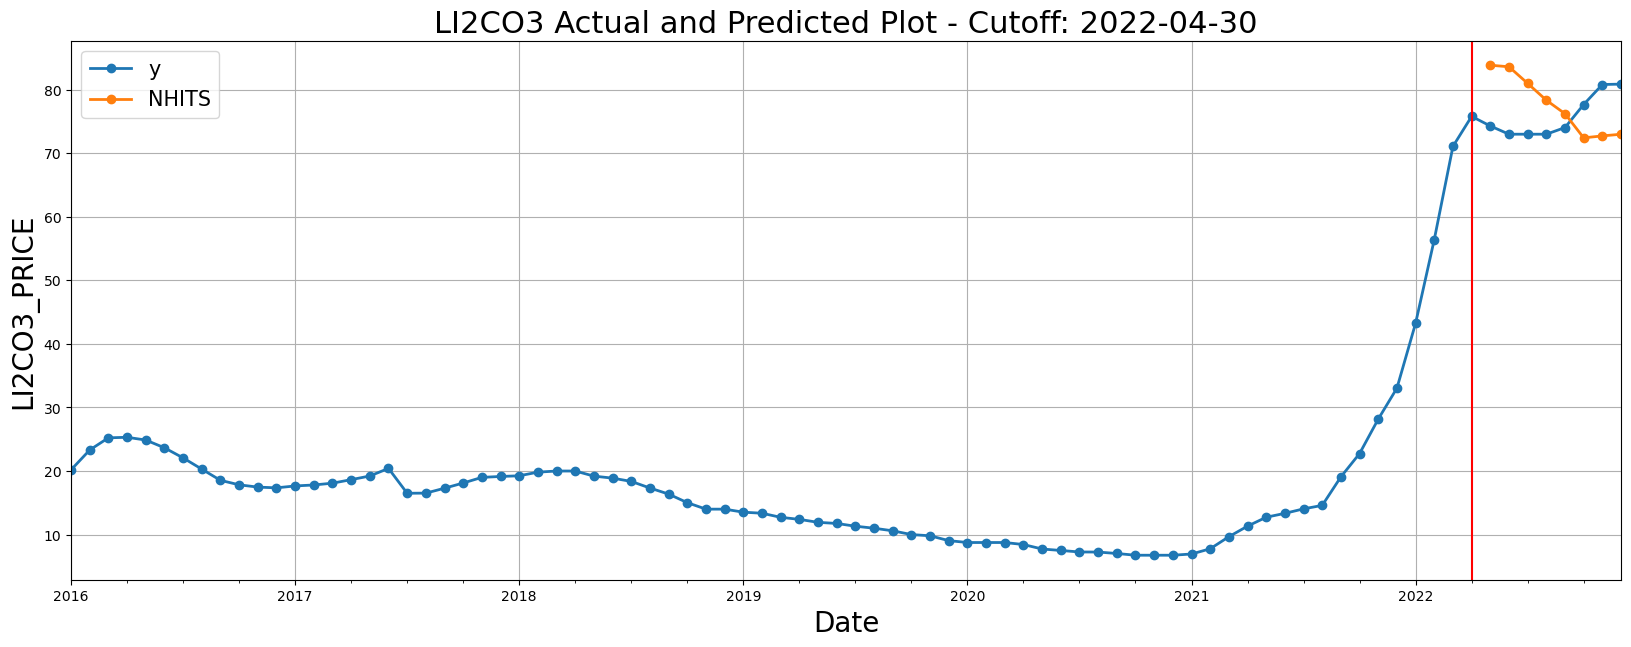

In [38]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [57]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)